<b>Note: </b> I had to continue to use `ChatOpenAI` instead of `ChatGoogleGenerativeAI` as `bind_function` is not yet supported by it.

In [1]:
!pip install langgraph langchain_openai python-dotenv

### Very Basic Example

![basic example](screenshots/screenshot_one.png)

In [2]:
from langgraph.graph import Graph

In [3]:
# Define functions for each node
def function_one(input_string):
    return input_string + " Hi "

def function_two(input_string):
    return input_string + "there"

In [4]:
# Initializing Graph object
workflow = Graph()

# Add nodes to the graph
workflow.add_node("node1", function_one)
workflow.add_node("node2", function_two)

# Add an edge between the nodes
workflow.add_edge("node1", "node2")

# Set entry and exit points for the graph
workflow.set_entry_point("node1")
workflow.set_finish_point("node2")

# Compile the graph app
chain = workflow.compile()

In [5]:
chain.invoke("Hello")

'Hello Hi there'

Observing the output at Node level

In [6]:
input = "Hello"

for output in chain.stream(input):
    # stream() yields dictionaries with output keyed by node name
    for key, value in output.items():
        print(f"Output from node: {key}: ")
        print("---")
        print(value)
    print("\n---\n")

Output from node: node1: 
---
Hello Hi 

---

Output from node: node2: 
---
Hello Hi there

---



### Making use of LLM

![basic example](screenshots/screenshot_two.png)

In [7]:
from dotenv import load_dotenv
import os

# Load environment variables from .env file
_ = load_dotenv()

In [8]:
from langchain_openai import ChatOpenAI

# Load environment variables from .env file
_ = load_dotenv()

# Set the model as ChatOpenAI
model = ChatOpenAI(model="gpt-4o-mini", temperature=0)

#Call the model with a user message
model.invoke('Hey there')

AIMessage(content='Hello! How can I assist you today?', response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 9, 'total_tokens': 18, 'completion_tokens_details': {'audio_tokens': 0, 'reasoning_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0ba0d124f1', 'finish_reason': 'stop', 'logprobs': None}, id='run-4244ccbb-4de4-4b69-a986-9e987279c631-0', usage_metadata={'input_tokens': 9, 'output_tokens': 9, 'total_tokens': 18})

In [9]:
model.invoke('Hey there').content

'Hello! How can I assist you today?'

In [10]:
def function_1(input_1):
    response = model.invoke(input_1)
    return response.content

def function_2(input_2):
    return "Agent Says: " + input_2

In [11]:
# Define a Langchain graph
workflow = Graph()

#calling node 1 as agent
workflow.add_node("agent", function_1)
workflow.add_node("node_2", function_2)

workflow.add_edge('agent', 'node_2')

workflow.set_entry_point("agent")
workflow.set_finish_point("node_2")

app = workflow.compile()

In [12]:
app.invoke("Hey there")

'Agent Says: Hello! How can I assist you today?'

In [13]:
input = 'Hey there'
for output in app.stream(input):
    # stream() yields dictionaries with output keyed by node name
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")

Output from node 'agent':
---
Hello! How can I assist you today?

---

Output from node 'node_2':
---
Agent Says: Hello! How can I assist you today?

---



### First Functional Agent App - City Temperature

![basic example](screenshots/screenshot_three.png)

#### Step 1: Parse the city mentioned

Let's extract the city that a user mentions in a query

In [14]:
def function_1(input_1):
    complete_query = "Your task is to provide only the city name based on the user query. \
        Nothing more, just the city name mentioned. Following is the user query: " + input_1
    response = model.invoke(complete_query)
    return response.content

def function_2(input_2):
    return "Agent Says: " + input_2

In [15]:
# Define a Langchain graph
workflow = Graph()

#calling node 1 as agent
workflow.add_node("agent", function_1)
workflow.add_node("node_2", function_2)

workflow.add_edge('agent', 'node_2')

workflow.set_entry_point("agent")
workflow.set_finish_point("node_2")

app = workflow.compile()

In [16]:
app.invoke("What's the temperature in Dubai?")


'Agent Says: Dubai'

Step 2: Adding a weather API call
What if we want the function 2 to take the city name and give us the weather for that city.

Well we know that Open Weather Map is integrated into LangChain

We need to install pyown, create an API key on the website of Open Weather Map (which takes a few hours to activate) and then run the cells below to get weather of a given city.

In [17]:
!pip install pyowm

In [17]:
from langchain_community.utilities import OpenWeatherMapAPIWrapper

weather = OpenWeatherMapAPIWrapper()

In [18]:
weather_data = weather.run("Dubai")
print(weather_data)

In Dubai, the current weather is as follows:
Detailed status: few clouds
Wind speed: 2.57 m/s, direction: 180°
Humidity: 78%
Temperature: 
  - Current: 24.77°C
  - High: 24.96°C
  - Low: 22.16°C
  - Feels like: 25.34°C
Rain: {}
Heat index: None
Cloud cover: 20%


Now, let's integrate this into function 2 and call the function two as a "tool" or "weather_agent" instead of "node_2" in our workflow.



In [19]:
def function_1(input_1):
    complete_query = "Your task is to provide only the city name based on the user query. \
        Nothing more, just the city name mentioned. Following is the user query: " + input_1
    response = model.invoke(complete_query)
    return response.content

def function_2(input_2):
    weather_data = weather.run(input_2)
    return weather_data

In [20]:
from langgraph.graph import Graph

workflow = Graph()

#calling node 1 as agent
workflow.add_node("agent", function_1)
workflow.add_node("tool", function_2)

workflow.add_edge('agent', 'tool')

workflow.set_entry_point("agent")
workflow.set_finish_point("tool")

app = workflow.compile()

In [21]:
print(app.invoke("What's the temperature in Dubai?"))

In Dubai, the current weather is as follows:
Detailed status: few clouds
Wind speed: 2.57 m/s, direction: 180°
Humidity: 78%
Temperature: 
  - Current: 24.77°C
  - High: 24.96°C
  - Low: 22.16°C
  - Feels like: 25.34°C
Rain: {}
Heat index: None
Cloud cover: 20%


In [22]:
input = "What's the temperature in Dubai?"
for output in app.stream(input):
    # stream() yields dictionaries with output keyed by node name
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")

Output from node 'agent':
---
Dubai

---

Output from node 'tool':
---
In Dubai, the current weather is as follows:
Detailed status: few clouds
Wind speed: 2.57 m/s, direction: 180°
Humidity: 78%
Temperature: 
  - Current: 24.77°C
  - High: 24.96°C
  - Low: 22.16°C
  - Feels like: 25.34°C
Rain: {}
Heat index: None
Cloud cover: 20%

---



Step 3 Adding another LLM Call to filter results

What if we only want the temperature? But current setup gives us the full weather report.

Well we can make another LLM call to filter data

In [23]:
def function_3(input_3):
    complete_query = "Your task is to provide info concisely based on the user query. Following is the user query: " + "user input"
    response = model.invoke(complete_query)
    return response.content

In [24]:
# assign AgentState as an empty dict
AgentState = {}

# messages key will be assigned as an empty array. We will append new messages as we pass along nodes. 
AgentState["messages"] = []

In [25]:
AgentState


{'messages': []}

Our goal is to have this state filled as: {'messages': [HumanMessage, AIMessage, ...]]}

Also now we need to modify our functions to pass info along the new AgentState

In [26]:
def function_1(state):
    messages = state['messages']
    user_input = messages[-1]
    complete_query = "Your task is to provide only the city name based on the user query. \
                    Nothing more, just the city name mentioned. Following is the user query: " + user_input
    response = model.invoke(complete_query)
    state['messages'].append(response.content) # appending AIMessage response to the AgentState
    return state

def function_2(state):
    messages = state['messages']
    agent_response = messages[-1]
    weather = OpenWeatherMapAPIWrapper()
    weather_data = weather.run(agent_response)
    state['messages'].append(weather_data)
    return state

def function_3(state):
    messages = state['messages']
    user_input = messages[0]
    available_info = messages[-1]
    agent2_query = "Your task is to provide info concisely based on the user query and the available information from the internet. \
                        Following is the user query: " + user_input + " Available information: " + available_info
    response = model.invoke(agent2_query)
    return response.content

In [27]:
from langgraph.graph import Graph

workflow = Graph()


workflow.add_node("agent", function_1)
workflow.add_node("tool", function_2)
workflow.add_node("responder", function_3)

workflow.add_edge('agent', 'tool')
workflow.add_edge('tool', 'responder')

workflow.set_entry_point("agent")
workflow.set_finish_point("responder")

app = workflow.compile()

In [28]:
inputs = {"messages": ["what is the temperature in Dubai?"]}
app.invoke(inputs)

'The current temperature in Dubai is 24.77°C, with a high of 24.96°C and a low of 22.16°C. It feels like 25.34°C.'

In [29]:
input = {"messages": ["what is the temperature in Dubai?"]}
for output in app.stream(input):
    # stream() yields dictionaries with output keyed by node name
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")

Output from node 'agent':
---
{'messages': ['what is the temperature in Dubai?', 'Dubai']}

---

Output from node 'tool':
---
{'messages': ['what is the temperature in Dubai?', 'Dubai', 'In Dubai, the current weather is as follows:\nDetailed status: few clouds\nWind speed: 2.57 m/s, direction: 180°\nHumidity: 78%\nTemperature: \n  - Current: 24.77°C\n  - High: 24.96°C\n  - Low: 22.16°C\n  - Feels like: 25.34°C\nRain: {}\nHeat index: None\nCloud cover: 20%']}

---

Output from node 'responder':
---
The current temperature in Dubai is 24.77°C, with a high of 24.96°C and a low of 22.16°C. It feels like 25.34°C.

---



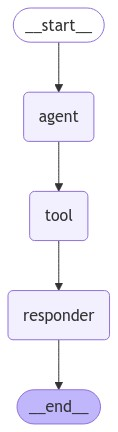

In [30]:
from IPython.display import Image, display

Image(app.get_graph().draw_mermaid_png())

As we notice that there is a lot of appending to the array going on, we can make it a bit easier with the following:
```python
from typing import TypedDict, Annotated, Sequence
import operator
from langchain_core.messages import BaseMessage
```

```python
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
```

It basically makes the state dictionary as saw previously, and also makes sure that any new message is appended to the messages array when we do the following:

```python
{"messages": [new_array_element]}
```

We also realize that our app is not capable of answering simple questions like "how are you?"


In [55]:
inputs = {"messages": ["how are you?"]}
app.invoke(inputs)

NotFoundError: Unable to find the resource

This is because we always want to parse a city and then find the weather.

We can make our agent smarter by saying only use the tool when needed, if not just respond back to the user.

The way we can do this LangGraph is:

- binding a tool to the agent
- adding a conditional edge to the agent with the option to either call the tool or not
- defining the criteria for the conditional edge as when to call the tool. We will define a function for this.

Let's start with the AgentState definition as mentioned a few cells above.

![basic example](screenshots/screenshot_four.png){ width=100% }{ height=100% }

In [31]:
from typing import TypedDict, Annotated, Sequence
import operator
from langchain_core.messages import BaseMessage


class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

In [32]:
from langchain_core.utils.function_calling import convert_to_openai_function
from langchain_community.tools.openweathermap import OpenWeatherMapQueryRun
from langchain_core.utils.function_calling import convert_to_openai_function

tools = [OpenWeatherMapQueryRun()]

model = ChatOpenAI(model="gpt-4o-mini", temperature=0, streaming=True)
functions = [convert_to_openai_function(t) for t in tools]
model = model.bind_functions(functions)

In [33]:
def function_1(state):
    messages = state['messages']
    response = model.invoke(messages)
    return {"messages": [response]}

In [34]:
from langgraph.prebuilt import ToolInvocation
import json
from langchain_core.messages import FunctionMessage
from langgraph.prebuilt import ToolExecutor

tool_executor = ToolExecutor(tools)

def function_2(state):
    messages = state['messages']
    last_message = messages[-1] # this has the query we need to send to the tool provided by the agent

    parsed_tool_input = json.loads(last_message.additional_kwargs["function_call"]["arguments"])

    # We construct an ToolInvocation from the function_call and pass in the tool name and the expected str input for OpenWeatherMap tool
    action = ToolInvocation(
        tool=last_message.additional_kwargs["function_call"]["name"],
        tool_input=parsed_tool_input['location'],
    )
    
    # We call the tool_executor and get back a response
    response = tool_executor.invoke(action)

    # We use the response to create a FunctionMessage
    function_message = FunctionMessage(content=str(response), name=action.tool)

    # We return a list, because this will get added to the existing list
    return {"messages": [function_message]}

/var/folders/wh/t7k8b0897kv58vlclsc1_0xh0000gn/T/ipykernel_74705/3407288375.py:6: LangGraphDeprecationWarning: ToolExecutor is deprecated as of version 0.2.0 and will be removed in 0.3.0. Use langgraph.prebuilt.ToolNode instead.
  tool_executor = ToolExecutor(tools)


In [35]:
def where_to_go(state):
    messages = state['messages']
    last_message = messages[-1]
    
    if "function_call" in last_message.additional_kwargs:
        return "continue"
    else:
        return "end"

In [36]:
# from langgraph.graph import Graph, END

# workflow = Graph()

# Or you could import StateGraph and pass AgentState to it
from langgraph.graph import StateGraph, END
workflow = StateGraph(AgentState)

workflow.add_node("agent", function_1)
workflow.add_node("tool", function_2)

# The conditional edge requires the following info below.
# First, we define the start node. We use `agent`.
# This means these are the edges taken after the `agent` node is called.
# Next, we pass in the function that will determine which node is called next, in our case where_to_go().

workflow.add_conditional_edges("agent", where_to_go,{   # Based on the return from where_to_go
                                                        # If return is "continue" then we call the tool node.
                                                        "continue": "tool",
                                                        # Otherwise we finish. END is a special node marking that the graph should finish.
                                                        "end": END
                                                    }
)

# We now add a normal edge from `tools` to `agent`.
# This means that if `tool` is called, then it has to call the 'agent' next. 
workflow.add_edge('tool', 'agent')

# Basically, agent node has the option to call a tool node based on a condition, 
# whereas tool node must call the agent in all cases based on this setup.

workflow.set_entry_point("agent")


app = workflow.compile()

In [37]:
from langchain_core.messages import HumanMessage

inputs = {"messages": [HumanMessage(content="What is the temperature in Dubai?")]}
app.invoke(inputs)

/var/folders/wh/t7k8b0897kv58vlclsc1_0xh0000gn/T/ipykernel_74705/3407288375.py:15: LangGraphDeprecationWarning: ToolInvocation is deprecated as of version 0.2.0 and will be removed in 0.3.0. Use langgraph.prebuilt.ToolNode instead.
  action = ToolInvocation(


{'messages': [HumanMessage(content='What is the temperature in Dubai?'),
  AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"location":"Dubai"}', 'name': 'open_weather_map'}}, response_metadata={'finish_reason': 'function_call', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0ba0d124f1'}, id='run-24ccd888-70d5-4dc2-bded-9f46ed9be553-0'),
  FunctionMessage(content='In Dubai, the current weather is as follows:\nDetailed status: few clouds\nWind speed: 2.57 m/s, direction: 180°\nHumidity: 78%\nTemperature: \n  - Current: 24.77°C\n  - High: 24.96°C\n  - Low: 22.16°C\n  - Feels like: 25.34°C\nRain: {}\nHeat index: None\nCloud cover: 20%', name='open_weather_map'),
  AIMessage(content='The current temperature in Dubai is approximately 24.77°C, with a "feels like" temperature of 25.34°C. The weather is partly cloudy, with a humidity level of 78%.', response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprin

In [38]:
inputs = {"messages": [HumanMessage(content="what is the temperature in dubai")]}
for output in app.stream(inputs):
    # stream() yields dictionaries with output keyed by node name
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")

Output from node 'agent':
---
{'messages': [AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"location":"Dubai"}', 'name': 'open_weather_map'}}, response_metadata={'finish_reason': 'function_call', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0ba0d124f1'}, id='run-7a3dd08e-588b-43be-a4f8-429356ba4e88-0')]}

---



/var/folders/wh/t7k8b0897kv58vlclsc1_0xh0000gn/T/ipykernel_74705/3407288375.py:15: LangGraphDeprecationWarning: ToolInvocation is deprecated as of version 0.2.0 and will be removed in 0.3.0. Use langgraph.prebuilt.ToolNode instead.
  action = ToolInvocation(


Output from node 'tool':
---
{'messages': [FunctionMessage(content='In Dubai, the current weather is as follows:\nDetailed status: few clouds\nWind speed: 2.57 m/s, direction: 180°\nHumidity: 78%\nTemperature: \n  - Current: 24.77°C\n  - High: 24.96°C\n  - Low: 22.16°C\n  - Feels like: 25.34°C\nRain: {}\nHeat index: None\nCloud cover: 20%', name='open_weather_map')]}

---

Output from node 'agent':
---
{'messages': [AIMessage(content='The current temperature in Dubai is approximately 24.77°C. It feels like 25.34°C, with a few clouds in the sky.', response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_f8dd36be86'}, id='run-57424ed0-a14c-4b8b-ba0f-b047a8f870c5-0')]}

---



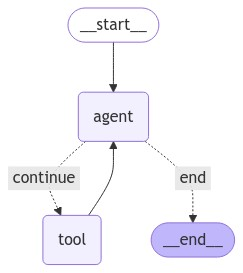

In [39]:
Image(app.get_graph().draw_mermaid_png())

### References

- YouTube Tutorial: https://www.youtube.com/watch?v=R8KB-Zcynxc&ab_channel=AIwithMisbah
- GitHub: https://github.com/menloparklab/LangGraphJourney/blob/main/LangGraphLearning.ipynb